<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания, и добиться, чтобы значение метрики *RMSE* на тестовой выборке было не более 48.

Этапы выполнения проекта:

1. Загружу данные и выполню их ресемплирование по одному часу.
2. Проанализирую данные.
3. Обучу разные модели с различными гиперпараметрами. Сделаю тестовую выборку размером 10% от исходных данных.
4. Проверю данные на тестовой выборке и сделаю выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

In [1]:
# Импортирую необходимые библиотеки.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Импортирую данные, отсортирую их по дате.
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
#df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
# Ресемплирую данные по 1 часу.
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


При загрузке датасета дату я сразу перевёл в формат DateTime и поместил его в индекс.

## Анализ

In [4]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [5]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Имеем 4416 записей, с 01 марта по 31 августа 2018 года. По количеству заказов в час - имеем разброс: от 0 (нет заказов) до 462.

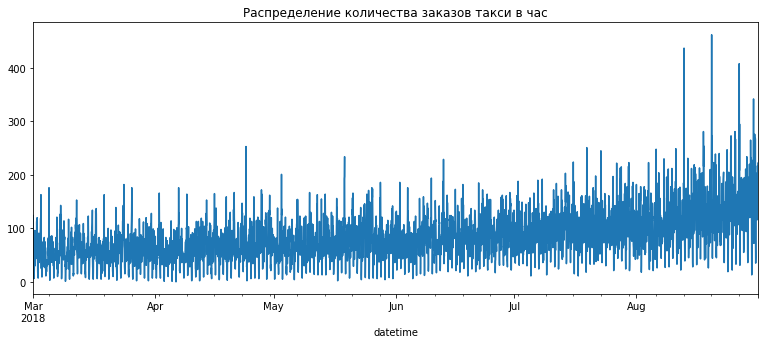

In [6]:
plt.figure(figsize=(13,5))
plt.title('Распределение количества заказов такси в час')
df['num_orders'].plot();

Временной ряд не стационарен. Со временем меняется его среднее значение и дисперсия. Имеются выбросы.

In [7]:
# Сделаю декомпозицию временного ряда, чтобы разложить его на тренды и сезонность
decomposed = seasonal_decompose(df['num_orders'])

Визуализирую тренд в середине анализируемого периода, в течение недели, с понедельника по воскресенье:

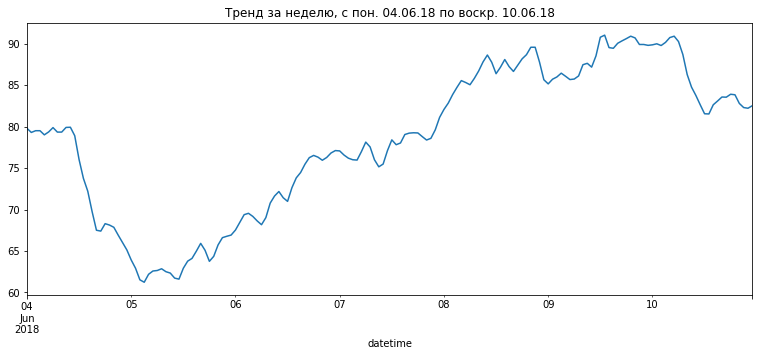

In [8]:
plt.figure(figsize=(13,5))
plt.title('Тренд за неделю, с пон. 04.06.18 по воскр. 10.06.18')
decomposed.trend['2018-06-04':'2018-06-10'].plot();

Визуализирую сезонность в середине анализируемого периода, в течение 2-х дней, в среду и в четверг:

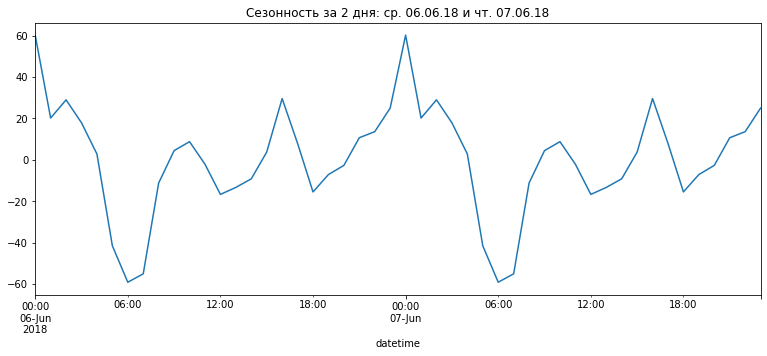

In [9]:
plt.figure(figsize=(13,5))
plt.title('Сезонность за 2 дня: ср. 06.06.18 и чт. 07.06.18')
decomposed.seasonal['2018-06-06':'2018-06-07'].plot();

Видно, что количество заказов меняется в течение недели (ко вторнику падают, далее со среды начинается рост, с пиком в период с пятницы по воскресенье). По сезонности видим, что количество заказов меняется волнами в течении дня (связано с графиком прилёта рейсов, день-ото дня эти волны повторяются по времени).

## Обучение

In [11]:
# Функция подбора количества лагов и скользящего среднего
def make_features(dframe, max_lag, rolling_mean_size):
    df_copy = dframe.copy()
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['dayofweek'] = df_copy.index.dayofweek
    for lag in range(1, max_lag + 1):
        df_copy['lag_{}'.format(lag)] = df_copy['num_orders'].shift(lag)
    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    df_copy = df_copy.dropna()
    feat = df_copy.drop(columns=['num_orders'])
    targ = df_copy.num_orders
    feat_train, feat_test, targ_train, targ_test = train_test_split(feat, targ, shuffle=False, test_size=0.1)

    model = LinearRegression()
     
    score = -cross_val_score(model, feat_train, targ_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit()).mean()
    return score

In [12]:
# Подберу оптимальное количество лагов и скользящее среднее
best_rmse = 9999999999999999999999999
best_lag = 0
best_rolling = 0
for r in range(1, 25):
    for i in range(1, 25):
        rmse = make_features(df, i, r)
        if rmse < best_rmse:
            best_rmse = rmse
            best_lag = i
            best_rolling = r
print('best_rmse:', best_rmse.round(2))
print('best_lag:', best_lag)
print('best_rolling:', best_rolling)

best_rmse: 27.03
best_lag: 24
best_rolling: 1


Для подбора параметров применил Линейную регрессию. Лучшее RMSE на ней получилось 27.03 при 24 логах и шириной скользящего среднего = 5.

Создам признаки для горизонта прогнозирования, в соответствии с этими найденными параметрами:

In [13]:
data = df.copy()
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
for l in range(1, best_lag + 1):
    data['lag_{}'.format(l)] = data['num_orders'].shift(l)
data['rolling_mean'] = data['num_orders'].shift().rolling(best_rolling).mean()
data.head(25)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0
2018-03-01 05:00:00,6,3,1,3,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0
2018-03-01 06:00:00,12,3,1,3,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
2018-03-01 07:00:00,15,3,1,3,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
2018-03-01 08:00:00,34,3,1,3,15.0,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0


In [14]:
# Удалю строки с пропусками в начале датасета
data = data.dropna()
data.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.0
2018-03-02 01:00:00,120,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,90.0
2018-03-02 02:00:00,75,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,120.0
2018-03-02 03:00:00,64,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,75.0
2018-03-02 04:00:00,20,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,64.0


In [15]:
# Выделю целевой признак
features = data.drop(columns=['num_orders'])
target = data.num_orders

In [16]:
# Разделю данные на обучающую и тестовую выборки.
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

**I. Линейная регрессия**

In [18]:
model_lr = LinearRegression()
rmse_lr = -cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error',
                           cv=TimeSeriesSplit()).mean()
print("RMSE:", rmse_lr)

RMSE: 27.025485513403424


**II. Дерево решений**

In [19]:
model_dtr= DecisionTreeRegressor(random_state=12345)
param_grid = {"max_depth" : range(10,13), 'min_samples_leaf': range(49,52)}
gsearch = GridSearchCV(model_dtr, param_grid = param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error',
                       cv=TimeSeriesSplit())
dtr_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-dtr_model.best_score_} при параметрах {dtr_model.best_params_}')

Лучшая RMSE: 29.210851045134756 при параметрах {'max_depth': 11, 'min_samples_leaf': 50}


**III. Случайный лес**

In [20]:
model_rfr= RandomForestRegressor(random_state=12345, n_jobs=-1)
param_grid = {
    "max_depth" : range(26,29),
    "n_estimators" : range(465,468)
}
gsearch = GridSearchCV(model_rfr, param_grid = param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error',
                       cv=TimeSeriesSplit())
rfr_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-rfr_model.best_score_} при параметрах ,{rfr_model.best_params_}')

Лучшая RMSE: 25.742673594750734 при параметрах ,{'max_depth': 26, 'n_estimators': 467}


**IV. LGBM**

In [21]:
model_lgbm = LGBMRegressor(random_state=12345, metric=rmse, n_jobs=-1)
param_grid = {
    'learning_rate' : np.arange(0.11, 0.14, 0.01),
    'boosting_type' : ['gbrt', 'dart', 'goss'],
    'max_depth' : range(3,6)
}
gsearch = GridSearchCV(model_lgbm, param_grid = param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error',
                       cv=TimeSeriesSplit(n_splits=5))
lgbm_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE: {-lgbm_model.best_score_} при параметрах ,{lgbm_model.best_params_}')

Лучшая RMSE: 25.431180317861315 при параметрах ,{'boosting_type': 'gbrt', 'learning_rate': 0.12, 'max_depth': 5}


In [22]:
# Запишу данные всех моделей вместе
models = []
models.append([round(rmse_lr, 2)])
models.append([round(-dtr_model.best_score_, 2)])
models.append([round(-rfr_model.best_score_, 2)])
models.append([round(-lgbm_model.best_score_, 2)])

In [23]:
model_table = pd.DataFrame(data=models, index=['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'LightGBM'],
                           columns=['RMSE'])

In [24]:
model_table

,RMSE
Линейная регрессия,27.03
Дерево решений,28.94
Случайный лес,25.55
LightGBM,25.37


**Вывод**

Самая лучшая модель: LightGBM (RMSE=25.37) со следующими настройками: 'boosting_type': 'gbrt', 'learning_rate': 0.12, 'max_depth': 4

## Тестирование

In [25]:
# Протестирую наилучшую модель на тестовой выборке
predictions = lgbm_model.predict(features_test)
print('RMSE модели LightGBM на тестовой выборке:', mean_squared_error(target_test, predictions, squared = False))

RMSE модели LightGBM на тестовой выборке: 41.46562880846064


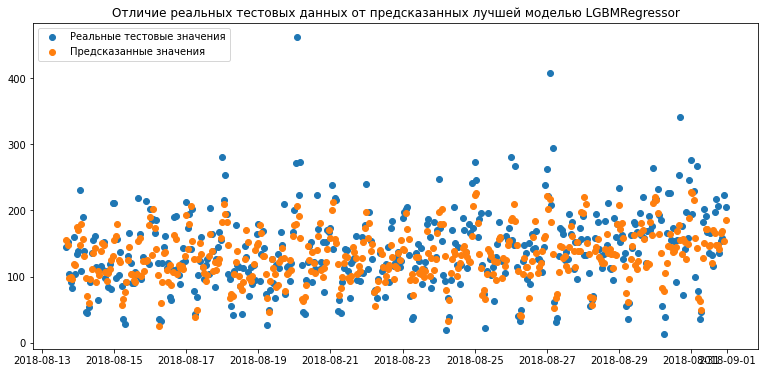

In [26]:
plt.figure(figsize=(13, 6)) 
plt.scatter(y=target_test, x=target_test.index, label='Реальные тестовые значения')
plt.scatter(y=predictions, x=target_test.index, label='Предсказанные значения')
plt.legend(loc='upper left')
plt.title('Отличие реальных тестовых данных от предсказанных лучшей моделью LGBMRegressor')
plt.show()

**Выводы**

Для прогнозирования количества заказов такси на следующий час в период пиковой нагрузки, были построены 4 модели предскания: 'Линейная регрессия', 'Дерево решений', 'Случайный лес', 'LightGBM'. 

Наиболее эффективная модель - 'LightGBM', она показала минимальную метрику RSME. 
RMSE модели на тестовой выборке (41,35) стал выше, чем на тренировочной (25.37), но удовлетворяет требованию в задании (Значение метрики RMSE на тестовой выборке должно быть не больше 48).

Визуализировал результаты, показывающие предсказанные значения лучшей модели и реальные тестовые значения.